torch.Tensor is the central class of the package. If you set its attribute .requires_grad as True, it starts to track all operations on it. When you finish your computation you can call .backward() and have all the gradients computed automatically. The gradient for this tensor will be accumulated into .grad attribute.

To stop a tensor from tracking history, you can call .detach() to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in with torch.no_grad():. This can be particularly helpful when evaluating a model because the model may have trainable parameters with requires_grad=True, but for which we don’t need the gradients.

There’s one more class which is very important for autograd implementation - a Function.

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a .grad_fn attribute that references a Function that has created the Tensor (except for Tensors created by the user - their grad_fn is None).

If you want to compute the derivatives, you can call .backward() on a Tensor. If Tensor is a scalar (i.e. it holds a one element data), you don’t need to specify any arguments to backward(), however if it has more elements, you need to specify a gradient argument that is a tensor of matching shape.

In [0]:
import torch

In [2]:
# Create a tensor and set requires_grad=True to track computation with it
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [3]:
# Doing a tensor operation
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


y was created as a result of an operation, so it has a grad_fn.

In [4]:
print(y.grad_fn)

In [13]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


.requires_grad_( ... ) changes an existing Tensor’s requires_grad flag in-place. The input flag defaults to False if not given.

In [6]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


# Gradients
Let’s backprop now. Because out contains a single scalar, out.backward() is equivalent to out.backward(torch.tensor(1.)).

In [0]:
out.backward() 

Print gradients d(out)/dx

In [16]:
print(x.grad) # x's requires_grad is already True. See above code

tensor([[13.5000, 13.5000],
        [13.5000, 13.5000]])


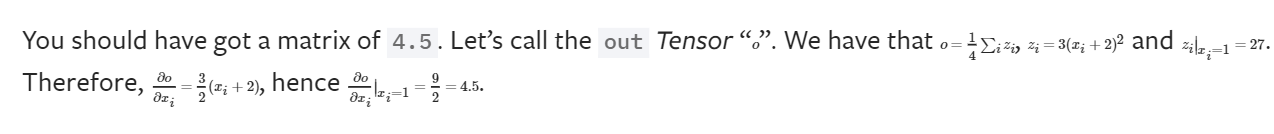

This characteristic of vector-Jacobian product makes it very convenient to feed external gradients into a model that has non-scalar output.

Now let’s take a look at an example of vector-Jacobian product:

In [21]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000: # norm() is Euclidean Norm
    y = y * 2

print(y)

tensor([-1051.1312,  1567.8872,   264.8730], grad_fn=<MulBackward0>)


Now in this case y is no longer a scalar. torch.autograd could not compute the full Jacobian directly, but if we just want the vector-Jacobian product, simply pass the vector to backward as argument:

In [22]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


You can also stop autograd from tracking history on Tensors with .requires_grad=True either by wrapping the code block in with torch.no_grad():

In [23]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


Or by using .detach() to get a new Tensor with the same content but that does not require gradients:

In [26]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)
